In [64]:
import sys
import os
import pandas as pd
import IPython.display as ipd
import numpy as np
from PyEMD import EEMD

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src')
import utility

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))

from sktime.utils.data_io import load_from_tsfile_to_dataframe

figure_path = module_path + '/figures/'

target_rate = 41000

import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import butter, lfilter

In [70]:
audio_file = '/home/andrine/Desktop/dataTromso/Hasse413/10756322_lungelyd_5.wav'

sr, audio = utility.read_wav_file(audio_file, target_rate)
audio = utility.denoise_audio(audio)
audio, sr = utility.downsample(audio, sr, 5000), 5000

duration = float(len(audio)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

lowcut = 120
highcut = 1200
FRAME_RATE = 5000

highcut_2 = 50

def butter_lowpass(highcut, fs, order = 5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #b, a = butter_lowpass(highcut, fs, order = order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=6)

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd


audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
audio = znorm(audio)

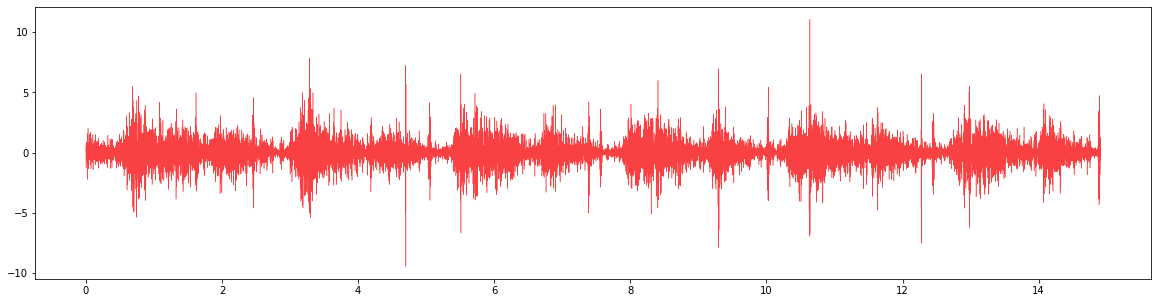

In [79]:
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


duration = float(len(audio)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

if len(x) != len(audio):
    x = np.linspace(0.0, N*T, N)

ax.plot(x, audio, linewidth = 0.5)

ipd.Audio(audio, rate = sr)

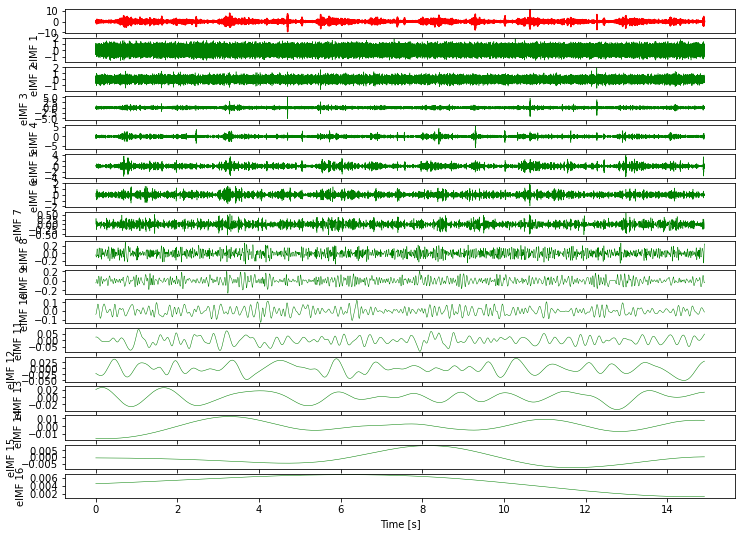

In [72]:
m_imf = 20
m_sift = 20
m_trials = 2
# Say we want detect extrema using parabolic method
eemd = EEMD(trials=m_trials)
eemd.spline_kind="slinear"
eemd.FIXE = m_sift


#filtered, index =  make_synthetic(audio, sr)
# Execute EEMD on S
eIMFs = eemd.eemd(audio, x, max_imf = m_imf)
nIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(x, audio, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(x, eIMFs[n], 'g', linewidth = 0.5)
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.show()

645.6748305709002
581.7962216203374
786.6749506602877
1364.2993488047175
2288.3217310648
1499.652943604329
693.1571995126309
653.8411345835268
436.5419864791396
479.89161395452186
371.4057773044407
360.0352781762544
338.3250365817629
238.5082930596408
186.41410746523297
359.24612596464976


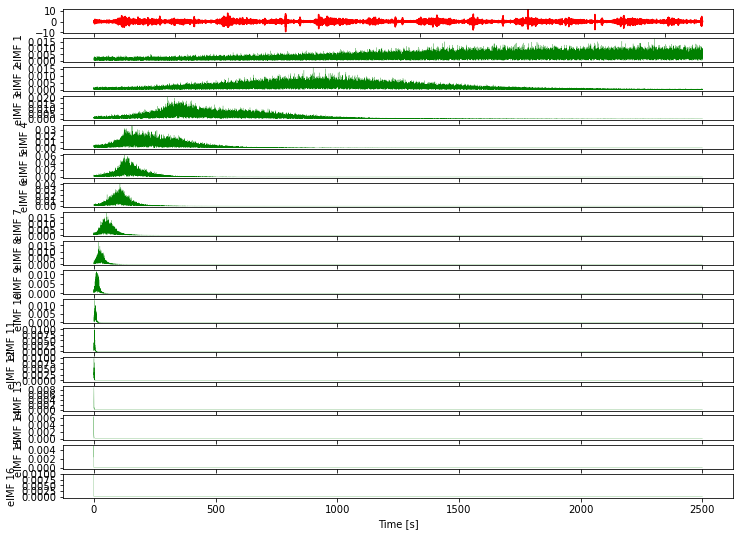

In [80]:
import scipy.fftpack

res = audio
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(x, audio, 'r')

for n in range(nIMFs):
    y = eIMFs[n]
    duration = float(len(y)) / sr
    T = 1.0/sr
    N = int(duration / T)
    x = np.linspace(0.0, N*T, N +1 )
    if len(x) != len(y):
        x = np.linspace(0.0, N*T, N)
    
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0, round(1.0/(2.0*T)), int(N/2))
    max_fft = max(np.abs(yf))
    print(max_fft)
    if (max_fft < 400 ) or (max_fft > 1000): # Region for wheezes
        res = res - y
    
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(xf, (2.0/N * np.abs(yf[:N//2])), 'g', linewidth = 0.2)
    
    #plt.plot(xf, yf, 'g', linewidth = 0.5)
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
    
plt.xlabel("Time [s]")
plt.show()

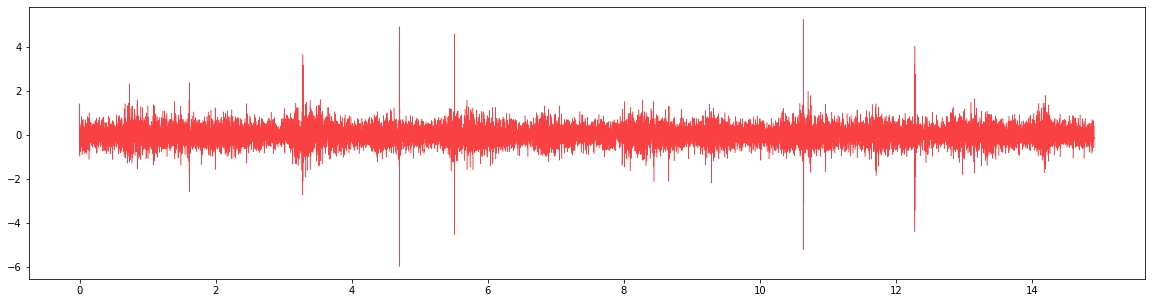

In [81]:
imf_sum = res
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


ax.plot(x, imf_sum, linewidth = 0.5)


ipd.Audio( imf_sum, rate = sr)

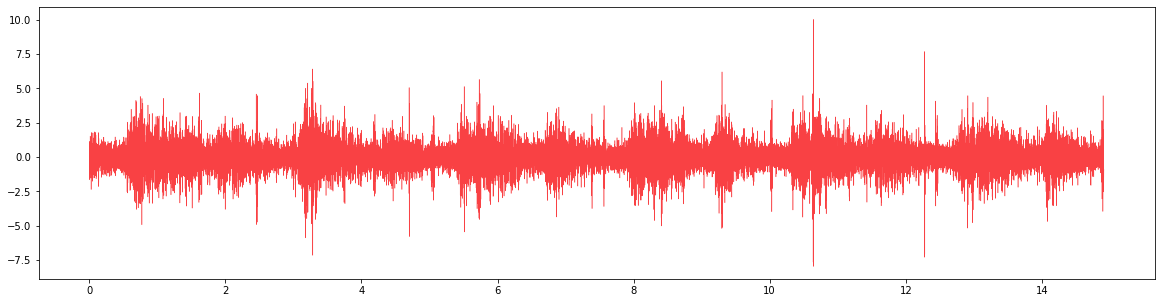

In [29]:
imf_sum = eIMFs[2] + eIMFs[3] + eIMFs[4] 
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


ax.plot(x, imf_sum, linewidth = 0.5)


ipd.Audio( imf_sum, rate = sr)

In [15]:
import scipy.fftpack
import random
import librosa


def make_synthetic(audio, sr):
    random_offset = random.random()
    test = 5*librosa.tone(400, sr=sr, length=1*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio, random_index

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

In [37]:
x[index]

10.8896

In [18]:
index

66722

In [19]:

ipd.Audio(eIMFs[8] , rate = sr)